## Example 3: Spectral Line Shapes
#### First time in Julia using our new RadiativeTransfer tools! https://github.com/RupeshJey/RadiativeTransfer.jl/
Part of ESE 156 Remote Sensing Class; 2020; 
Christian Frankenberg
__________
The purpose of this notebook is to learn how to compute line-shapes (in our case mostly of rotational-vibrational transition lines), what processes determine line-shapes and how the dependencies in the line-shape on pressure and temperature could actually be used to our advantage in a retrieval system. 

#### Basic tools
We are making use of the HITRAN database (https://www.cfa.harvard.edu/hitran/), see a list of tutorials here: https://www.youtube.com/playlist?list=PLqOG3cBizTUFQw5lwpkCpQFCVuxHTZgrT

There are other spectroscopic linelists but we are focusing on HITRAN only here. In addition, there are more complex line-shapes that we are not treating here, including collisional narrowing (https://journals.aps.org/pr/abstract/10.1103/PhysRev.89.472), line-mixing (e.g. https://aip.scitation.org/doi/abs/10.1063/1.478724), collision-induced absorption (CIA) (https://www.sciencedirect.com/science/article/abs/pii/S0022407311003773).

#### How to install RadiativeTransfer.jl ?
```julia
pkg> add https://github.com/RupeshJey/RadiativeTransfer.jl
```
as simple as that...


---

### Line-shape (background covered in class):
If we have a line-strength S (in cm$^{-1}$ cm$^2$/molecule) for a specific transition at $\nu_0$, we can compute the cross section as:
$$\sigma(\nu) = S\Phi(\nu-\nu_0)\,,$$
where $\Phi(\nu-\nu_0)$ denotes the line-shape function (in 1/cm$^{-1}$), which is normalized to 1: $\int_{-\infty}^\infty \Phi(\nu-\nu_0) d\nu=1$.

There are several processes that affect the shape and width of $\Phi$ and we will walk through the most important ones here now

##### Doppler Broadening
Doppler broadening is caused by a simple doppler shift of emitted and absorbed frequencies, caused by the relative velocities of the molecules along the line of sight. A doppler shifted apparent frequency from the centroid frequency $\nu_0$ can be described as:
$$\nu = \nu_0\left(1+\frac{v_r}{c}\right)\,$$
where $v_r$ is the relative velocity of the absorbing photon along the line of sight. The doppler shift is then simply
$$ \Delta\nu = \nu_0\frac{v_r}{c}$$

Let us take a simple example with the satellite flying at 7km/s and either staring into the flight direction (technically, it wouldn't see the atmosphere then but let's ignore this) or looking into the back:
____


In [1]:
# Speed of light (in m/s)
c = 299792458.0

# Relative velocity (in m/s)
vᵣ = 7000.0

# Center wavenumber (say 1600nm, which is 1e7/1600=6250 cm$^{-1}$)
v₀ = 6250.0

# Doppler shift:
Δ_ν = ( v₀ * vᵣ) / c

# Just writing out doppler shift in wavenumbers and wavelengths
println("Doppler shift = $Δ_ν cm-1")
println("Doppler shift = $(1e7/(v₀-Δ_ν)-1e7/v₀) nm")

Doppler shift = 0.14593429164919153 cm-1
Doppler shift = 0.03736005100040529 nm


#### Random movements of molecules in gases lead to doppler broadening effects

In the one-dimensional case along say the x-axis (we only observe the distribution along one line of sight), the speed of moleculed is distributed according to the Maxwell-Boltzmann distribution:
$$f(v_x) = \sqrt{\frac{m}{2\pi kT}}\exp{\left(-\frac{mv_x^2}{2kT}\right)}.$$

We can then define a Doppler width $\Delta \nu_D$ as
$$ \Delta \nu_D = \frac{\nu_0}{c}\sqrt{\frac{2kT}{m}}= \frac{\nu_0}{c}\sqrt{\frac{2RT}{M}}\,$$
which yields the following line-shape:
$$\phi_D(\nu) = \frac{1}{\Delta \nu_D \sqrt{\pi}}\exp{\left(-\frac{(\nu-\nu_0)^2}{\Delta \nu^2_D}\right)}=\,,$$
which is a Gaussian distribution.

Let us put in some numbers with R=8.3144598 J/K/mol at 6000cm$^{-1}$:
<li> T = 220K, 290K
<li> M = 16g/mol (CH$4$) or 44g/mol (CO$_2$)
 
---

$ \Delta \nu_D(290K,CO_2)=$ 0.0066cm$^{-1}$

$ \Delta \nu_D(220K,CO_2)=$ 0.0058cm$^{-1}$

$ \Delta \nu_D(290K,CH_4)=$ 0.0110cm$^{-1}$

$ \Delta \nu_D(290K,CH_4)=$ 0.0096cm$^{-1}$

Mulitply with about 1.6585 (2$\sqrt{ln(2)}$) to get FWHM

----
#### Natural and collisional broadening
Due to the Heisenberg principle
$$\Delta E \Delta t \sim h/2\pi\,,$$
As $\Delta E$ is $h\Delta\nu$, we can write:
$$\Delta\nu = \frac{h/2\pi}{\tau}$$

The natural line-width is defined by using the radiative lifetime but mostly negligible as the natural lifetime of the upper state is usually much much smaller than the "perturbed" lifetime in the presence of quencher (e.g. through collisions). Again, there are exceptions.

Collisions between molecules reduce the lifetime of the upper state, thus widening the line width. This behavor gives rise to the so-called Lorentz lineshape.

$$\phi_L(\nu) = \frac{\alpha_L}{\pi \left[(\nu-\nu_0)^2+\alpha_L^2\right]}$$

$\alpha_L$ depends linearly on the number density of the perturbing molecules and the relative speed of the collision partners (thus scales linearly with pressure and with $\sqrt{T}$).

----
#### Voigt lineshape
The Voigt line-shape is the combination of Doppler and Pressure broadening (convolution of the two) but cannot be evaluated analytically. However, there are numerical routines to compute it efficiently.

----
#### Other more complex lineshapes
Once you dig deeper, there are various other more complex line-shapes (and line-mixing effects), which we ignore for now as the Voigt line-shape can provide very reasonable results. See, for instance, https://www.degruyter.com/view/j/pac.2014.86.issue-12/pac-2014-0208/pac-2014-0208.xml

In [22]:
using Plots
using Pkg.Artifacts
using RadiativeTransfer
using RadiativeTransfer.CrossSection
using PlotlyJS
using LaTeXStrings

┌ Info: Precompiling PlotlyJS [f0f68f2c-4968-5e81-91da-67840de0976a]
└ @ Base loading.jl:1278
┌ Warning: `@get!(dict, key, default)` at /Users/cfranken/.julia/packages/WebIO/nTMDV/src/scope.jl:160 is deprecated, use `get!(()->default, dict, key)` instead.
└ @ Base deprecated.jl:204
┌ Warning: `@get!(dict, key, default)` at /Users/cfranken/.julia/packages/WebIO/nTMDV/src/scope.jl:357 is deprecated, use `get!(()->default, dict, key)` instead.
└ @ Base deprecated.jl:204
┌ Warning: `@get!(dict, key, default)` at /Users/cfranken/.julia/packages/Lazy/mAoZN/src/collections.jl:49 is deprecated, use `get!(()->default, dict, key)` instead.
└ @ Base deprecated.jl:204


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4687130389782184639\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-2514120126505218433\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-4687130389782184639\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

### Please donwload ftp://fluo.gps.caltech.edu/XYZT_hitran/hitran_molec_id_2_CO2.par into your files folder
In the future, this will become obsolete (downloads should be automatic) but we are still fixing these things. If you are wonderin abut molecule and isotope IDs, they are defined for HITRAN here: https://hitran.org/docs/molec-meta/, https://hitran.org/docs/iso-meta/ 

In [17]:
co2_par = CrossSection.read_hitran("files/hitran_molec_id_2_CO2.par", mol=2, iso=1, ν_min=6214.4, ν_max=6214.8);
line_voigt   = make_hitran_model(co2_par, Voigt())
line_doppler = make_hitran_model(co2_par, Doppler())
line_lorentz = make_hitran_model(co2_par, Lorentz())
# Specify our wavenumber grid
ν = 6210:0.001:6220;

In [33]:
cs_co2_1atm   = absorption_cross_section(line_voigt, ν, 1013.0     , 296.0); 
cs_co2_075atm = absorption_cross_section(line_voigt, ν, 0.75*1013.0, 296.0); 
cs_co2_05atm  = absorption_cross_section(line_voigt, ν, 0.5*1013.0 , 296.0); 
cs_co2_025atm = absorption_cross_section(line_voigt, ν, 0.25*1013.0, 296.0); 
cs_co2_01atm  = absorption_cross_section(line_voigt, ν, 0.1*1013.0 , 296.0); 

# Get some more line-shapes just for Doppler and Voigt
cs_co2_01atm    = absorption_cross_section(line_voigt,   ν, 0.1*1013.0 , 296.0);
cs_co2_doppler  = absorption_cross_section(line_doppler, ν, 0.1*1013.0 , 296.0);
cs_co2_lorentz  = absorption_cross_section(line_lorentz, ν, 0.1*1013.0 , 296.0);

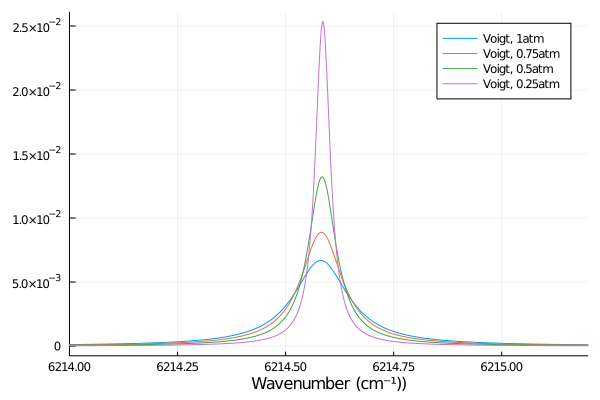

In [50]:
gr()
ff = 1e20;
plot(ν,  ff*cs_co2_1atm,   label="Voigt, 1atm", yformatter = :scientific)
plot!(ν, ff*cs_co2_075atm,label="Voigt, 0.75atm")
plot!(ν, ff*cs_co2_05atm, label="Voigt, 0.5atm")
plot!(ν, ff*cs_co2_025atm,label="Voigt, 0.25atm")

xlims!((6214,6215.2))
xlabel!("Wavenumber (cm⁻¹))")

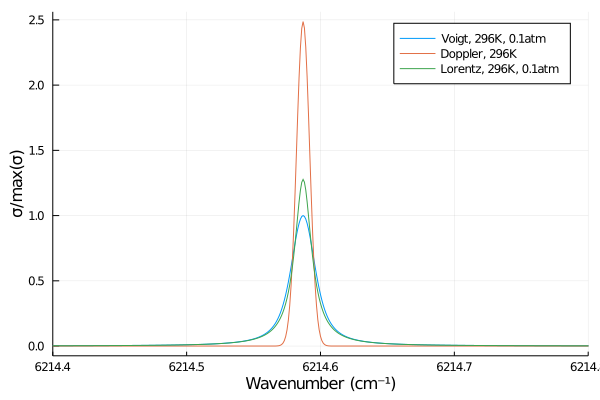

In [51]:
plot( ν, cs_co2_01atm   /maximum(cs_co2_01atm) ,label="Voigt, 296K, 0.1atm")
plot!(ν, cs_co2_doppler /maximum(cs_co2_01atm) ,label="Doppler, 296K")
plot!(ν, cs_co2_lorentz /maximum(cs_co2_01atm) ,label="Lorentz, 296K, 0.1atm")
xlims!((6214.4,6214.8))

ylabel!("σ/max(σ)")
xlabel!("Wavenumber (cm⁻¹)")

## From an individual line to a band
Here, we will just compute an entire band of CO$_2$ (a few to be precise) and look at some simple behavior, e.g. the re-distribution of individual lines in the P and R branch with changing temperature.

In [52]:
co2_par_band = CrossSection.read_hitran("files/hitran_molec_id_2_CO2.par", mol=2, iso=1, ν_min=6000.0, ν_max=6400.0);
band_voigt   = make_hitran_model(co2_par_band , Voigt())

HitranModel
  hitran: HitranTable{Float64}
  broadening: Voigt Voigt()
  wing_cutoff: Int64 40
  vmr: Int64 0
  CEF: HumlicekWeidemann32SDErrorFunction HumlicekWeidemann32SDErrorFunction()
  architecture: RadiativeTransfer.Architectures.CPU RadiativeTransfer.Architectures.CPU()


In [53]:
ν_band = 6300:0.01:6400;
σ_co2_Voigt220 = absorption_cross_section(band_voigt, ν_band, 1013.0 , 220.0);
σ_co2_Voigt290 = absorption_cross_section(band_voigt, ν_band, 1013.0 , 290.0);

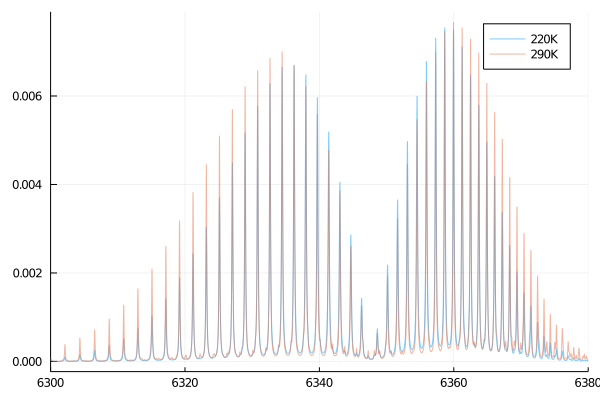

In [54]:
plot( ν_band, ff*σ_co2_Voigt220, alpha=0.5, label="220K")
plot!(ν_band, ff*σ_co2_Voigt290, alpha=0.5, label="290K")
xlims!((6300,6380))

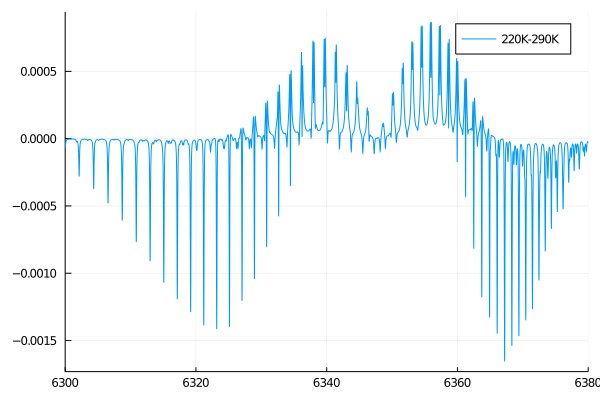

In [55]:
plot(ν_band, ff*(σ_co2_Voigt220 - σ_co2_Voigt290), label="220K-290K")
xlims!((6300,6380))